### Preparation

In [1]:
import torch, timm
import numpy as np
import sys
import copy
import os
from os import makedirs
from os.path import exists
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import os
from torch.utils.data import TensorDataset

In [ ]:
"""
replace the below with your setup
"""
exp = 'exp01'
victim_class = 8
attack_target = 5
dataset_name = "cifar10"
attack_method = "badnet"
detection_name = "delta_influence" # what detection you are using
user_name = "xxx"
repo_dir = f"/data/{user_name}/github/poisoning-gradient-matching/open_source_delta_influence" 
clean_data_dir = f"{repo_dir}/clean_data/cifar10"

os.chdir(repo_dir)
print(os.getcwd())
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())
import forest
print(forest.__file__)

sys.path.append(f'{repo_dir}/helpers/corrective-unlearning-bench/src')
import methods, resnet
from opts import parse_args 
from utils import seed_everything, SubsetSequentialSampler, get_targeted_classes  
from dataset import load_dataset, DatasetWrapper, manip_dataset, get_deletion_set

In [3]:
##### THE PART WE NEED TO MODIFY ####
model_name = 'ResNet18'
dataset = 'CIFAR10'
num_classes = 10
unlearn_method = 'BadT' # choices=['Naive', 'EU', 'CF', 'Scrub', 'BadT', 'SSD', 'ActivationClustering', 'SpectralSignature', 'DeltaInfluence']
#####################################
dataset_method = None # no need to specify here since we prepared the poisoned set already
forget_set_size = None # Number of samples to be manipulated
deletion_size = None # Number of samples to be deleted
k = -1 # 'All layers are freezed except the last-k layers, -1 means unfreeze all layers'
factor = 0.1 # Magnitude to decrease weights
### scrub ###
kd_T = 4 # Knowledge distilation temperature for SCRUB
alpha = 0.001 # KL from og_model constant for SCRUB, higher incentivizes closeness to ogmodel
msteps = 400 # Maximization steps on forget set for SCRUB
### SSD ###
SSDdampening = 1.0 # SSD: lambda aka dampening constant, lower leads to more forgetting
SSDselectwt = 10.0 # SSD: alpha aka selection weight, lower leads to more forgetting
### unsure method ###
rsteps = 800 # InfRe when to stop retain set gradient descent
ascLRscale = 1.0 # AL/InfRe: scaling of lr to use for gradient ascent

# Optimizer Params
batch_size = 512 # input batch size for training
pretrain_iters = 40 # number of epochs to train, 7500
train_iters = 40
unlearn_iters = 40 # number of epochs to train (unlearning), 1000
pretrain_lr = 0.025
unlearn_lr = 0.025
wd = 0.0005
# Defaults
data_dir = '../data/'
save_dir = '../logs/'
exp_name = 'unlearn'
device = 'cuda'

class args_specify:
  def __init__(
        self,
        model_name,
        dataset,
        dataset_method,
        unlearn_method,
        num_classes,
        forget_set_size,
        deletion_size,
        k,
        factor,
        kd_T,
        alpha,
        msteps,
        SSDdampening,
        SSDselectwt,
        rsteps,
        ascLRscale,
        batch_size,
        pretrain_iters,
        train_iters,
        unlearn_iters,
        pretrain_lr,
        unlearn_lr,
        wd,
        data_dir,
        save_dir,
        exp_name,
        device,
            ):
        self.model = model_name
        self.dataset = dataset
        self.dataset_method = dataset_method
        self.unlearn_method = unlearn_method
        self.num_classes = num_classes
        self.forget_set_size = forget_set_size
        self.deletion_size = deletion_size
        self.k = k
        self.factor = factor
        self.kd_T = kd_T
        self.alpha = alpha
        self.msteps = msteps
        self.SSDdampening =SSDdampening
        self.SSDselectwt = SSDselectwt
        self.rsteps = rsteps
        self.ascLRscale = ascLRscale
        self.batch_size = batch_size
        self.pretrain_iters = pretrain_iters
        self.train_iters = train_iters
        self.unlearn_iters = unlearn_iters
        self.pretrain_lr = pretrain_lr
        self.unlearn_lr = unlearn_lr
        self.wd = wd
        self.data_dir = data_dir
        self.save_dir = save_dir
        self.exp_name = exp_name
        self.device = device

opt = args_specify(
    model_name,
    dataset,
    dataset_method,
    unlearn_method,
    num_classes,
    forget_set_size,
    deletion_size,
    k,
    factor,
    kd_T,
    alpha,
    msteps,
    SSDdampening,
    SSDselectwt,
    rsteps,
    ascLRscale,
    batch_size,
    pretrain_iters,
    train_iters,
    unlearn_iters,
    pretrain_lr,
    unlearn_lr,
    wd,
    data_dir,
    save_dir,
    exp_name,
    device
)
torch.multiprocessing.set_sharing_strategy('file_system')
seed_everything(seed=3017)
if opt.device == 'cuda':
    assert(torch.cuda.is_available())

### Get the victim model

In [4]:
##### THE PART WE NEED TO MODIFY ####
net = ['ResNet18']
dataset = 'CIFAR10'
#####################################
recipe = 'gradient-matching'
threatmodel = 'single-class'
poisonkey = None
modelkey = None
eps = 16
budget = 0.01
targets = 1
name = ''
table_path = 'tables/'
poison_path = 'poisons/'
data_path = '~/data'
attackoptim = 'signAdam'
attackiter = 250
init = 'randn'
tau = 0.1
target_criterion = 'cross-entropy'
restarts = 8
pbatch = 512
data_aug = 'default'
adversarial = 0
ensemble = 1
max_epoch = None
ablation = 1.0
loss = 'similarity'
centreg = 0
normreg = 0
repel = 0
nadapt = 2
vruns = 1
vnet = None
optimization = 'conservative'
epochs = 40
gradient_noise = None
gradient_clip = None
lmdb_path = None
benchmark = ''
benchmark_idx = 0
save = None
local_rank = None
pretrained = False
noaugment = False
cache_dataset = False
pshuffle = False
dryrun = False
class model_args_specify:
  def __init__(
        self,
        net,
        dataset,
        recipe,
        threatmodel,
        poisonkey,
        modelkey,
        eps,
        budget,
        targets,
        name,
        table_path,
        poison_path,
        data_path,
        attackoptim,
        attackiter,
        init,
        tau,
        target_criterion,
        restarts,
        pbatch,
        data_aug,
        adversarial,
        ensemble,
        max_epoch,
        ablation,
        loss,
        centreg,
        normreg,
        repel,
        nadapt,
        vruns,
        vnet,
        optimization,
        epochs,
        gradient_noise,
        gradient_clip,
        lmdb_path,
        benchmark,
        benchmark_idx,
        save,
        local_rank,
        pretrained,
        noaugment,
        cache_dataset,
        pshuffle,
        dryrun
            ):
        self.net = net
        self.dataset = dataset
        self.recipe = recipe
        self.threatmodel = threatmodel
        self.poisonkey = poisonkey
        self.modelkey = modelkey
        self.eps = eps
        self.budget = budget
        self.targets = targets
        self.name = name
        self.table_path = table_path
        self.poison_path = poison_path
        self.data_path =data_path
        self.attackoptim = attackoptim
        self.attackiter = attackiter
        self.init = init
        self.tau = tau
        self.target_criterion = target_criterion
        self.restarts = restarts
        self.pbatch = pbatch
        self.data_aug = data_aug
        self.adversarial = adversarial
        self.ensemble = ensemble
        self.max_epoch = max_epoch
        self.ablation = ablation
        self.loss = loss
        self.centreg = centreg
        self.normreg = normreg
        self.repel = repel
        self.nadapt = nadapt
        self.vruns = vruns
        self.vnet = vnet
        self.optimization = optimization
        self.epochs = epochs
        self.gradient_noise = gradient_noise
        self.gradient_clip = gradient_clip
        self.lmdb_path = lmdb_path
        self.benchmark = benchmark
        self.benchmark_idx = benchmark_idx
        self.save = save
        self.local_rank = local_rank
        self.pretrained = pretrained
        self.noaugment = noaugment
        self.cache_dataset = cache_dataset
        self.pshuffle = pshuffle
        self.dryrun = dryrun

model_args = model_args_specify(
    net,
    dataset,
    recipe,
    threatmodel,
    poisonkey,
    modelkey,
    eps,
    budget,
    targets,
    name,
    table_path,
    poison_path,
    data_path,
    attackoptim,
    attackiter,
    init,
    tau,
    target_criterion,
    restarts,
    pbatch,
    data_aug,
    adversarial,
    ensemble,
    max_epoch,
    ablation,
    loss,
    centreg,
    normreg,
    repel,
    nadapt,
    vruns,
    vnet,
    optimization,
    epochs,
    gradient_noise,
    gradient_clip,
    lmdb_path,
    benchmark,
    benchmark_idx,
    save,
    local_rank,
    pretrained,
    noaugment,
    cache_dataset,
    pshuffle,
    dryrun
)

model_setup = forest.utils.system_startup(model_args)
# load poisoned model
print(device)
model_exp = f'{dataset_name}/{exp}'
load_model_name = 'victim.pth'
models_dir = f'{repo_dir}/notebooks/{attack_method}/{model_exp}/models/'

model = forest.Victim(model_args, setup=model_setup)
model = model.load_model(models_dir + load_model_name)
model = model.to(device)

Currently evaluating -------------------------------:
Saturday, 09. November 2024 08:40PM
CPUs: 1, GPUs: 1 on compute-permanent-node-506.
GPU : NVIDIA A100-SXM4-80GB
cuda
ResNet18 model initialized with random key 1572774445.


Load manip_idx and detected_idx

In [5]:
manip_idx = np.load(f'{repo_dir}/notebooks/{attack_method}/{model_exp}/poison_info/manip_idx.npy')

# pass the detected idx
detected_idx_path = '/data/xxx/github/poisoning-gradient-matching/open_source_delta_influence/notebooks/badnet/cifar10/exp01/detected/aux_MM_50_detected_indices.npy' # replace 'xxx' with your path
detected_idx = np.load(detected_idx_path)

set1 = set(detected_idx.tolist())
set2 = set(manip_idx.tolist())

common_elements = set1.intersection(set2)
common_tensor = torch.tensor(list(common_elements))

print(f" The algorithm returns {len(detected_idx)} poisons...\n")
print(f" among them {len(common_tensor)} are true poisons (there're {len(manip_idx)} poisons in total -> [{(len(common_tensor)/(len(manip_idx)/100)):.2f}%] detected) \n\n their indices: {common_tensor.tolist()}\n")
print(f" the other {len(detected_idx) - len(common_tensor)} are actually cleans...")

 The algorithm returns 3265 poisons...

 among them 500 are true poisons (there're 500 poisons in total -> [100.00%] detected) 

 their indices: [40963, 34825, 14348, 38927, 6160, 2065, 8214, 40983, 10268, 49182, 49195, 8250, 4159, 49220, 47179, 6219, 10317, 8278, 30807, 14427, 34910, 26720, 43119, 18546, 20594, 10354, 10361, 20604, 43136, 37002, 30860, 41112, 14497, 2212, 49321, 24748, 10416, 22712, 47291, 6143, 4287, 8384, 12481, 39106, 193, 12490, 4298, 22736, 37072, 35036, 2272, 20705, 49378, 30948, 22758, 8429, 24821, 14581, 2298, 41218, 18691, 20739, 35078, 22791, 12557, 47373, 45327, 39191, 39193, 2333, 47395, 26923, 28985, 6459, 4412, 31037, 16716, 43350, 10585, 2395, 31069, 8544, 353, 35177, 29055, 31104, 45447, 43400, 10639, 49553, 31121, 29075, 18840, 31131, 41373, 49571, 39335, 43432, 39336, 45486, 27061, 31170, 35266, 33225, 459, 18892, 465, 31188, 33240, 8665, 2523, 12772, 14821, 8678, 14826, 25072, 37362, 29175, 20984, 49657, 47610, 2558, 39424, 21005, 27153, 39442, 1077

Get the poisoned dataset

In [6]:
poison_data_path = f'{repo_dir}/notebooks/{attack_method}/{model_exp}/data'

patched_images_tensor = torch.load(os.path.join(poison_data_path, 'patched_images.pt')) 
patched_labels_tensor = torch.load(os.path.join(poison_data_path, 'patched_labels.pt'))

# note that for badnet patching, the saved dataset is raw data (not normalized) (therefore we need to normalize it when unlearn)
normalize = transforms.Normalize(mean=[0.49147, 0.48226, 0.44677], std=[0.24703, 0.24349, 0.26159])
normalized_patched_images = [normalize(img) for img in patched_images_tensor]
normalized_patched_images_tensor = torch.stack(normalized_patched_images)  

patched_dataset = torch.utils.data.TensorDataset(normalized_patched_images_tensor, patched_labels_tensor)

full_idx = np.arange(len(patched_labels_tensor))
retain_idx = np.setdiff1d(full_idx, detected_idx)
len(detected_idx), len(retain_idx)

(3265, 46735)

In [7]:
idxes_in_manipidx = copy.deepcopy(manip_idx)
idxes_in_manipidx.sort()

manip_dict = {}
for i in range(len(idxes_in_manipidx)):
    manip_dict[idxes_in_manipidx[i]] = attack_target  # all these poisoned examples' labels are maliciously set to 'attack_target'

train_labels = patched_labels_tensor
delete_idx = detected_idx

In [8]:
wpoisoned_train_set = DatasetWrapper(patched_dataset, manip_dict, mode='unlearn', corrupt_val=None, corrupt_size=None, delete_idx=delete_idx)
retain_loader = torch.utils.data.DataLoader(wpoisoned_train_set, batch_size=opt.batch_size, shuffle=False, sampler=SubsetSequentialSampler(retain_idx), num_workers=1, pin_memory=True)
delete_loader = torch.utils.data.DataLoader(wpoisoned_train_set, batch_size=opt.batch_size, shuffle=False, sampler=SubsetSequentialSampler(delete_idx), num_workers=1, pin_memory=True)

In [9]:
clean_cifar10_data_path = clean_data_dir
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49147, 0.48226, 0.44677), (0.24703, 0.24349, 0.26159))
])
clean_testset = torchvision.datasets.CIFAR10(root=clean_cifar10_data_path, train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(clean_testset, batch_size=opt.batch_size, shuffle=False, num_workers=1, pin_memory=True)

Files already downloaded and verified


In [10]:
opt.unlearn_method, opt.exp_name

('BadT', 'unlearn')

In [11]:
opt.save_dir = f'{repo_dir}/notebooks/{attack_method}/{model_exp}/unlearn_logs'
opt.dataset_method = 'badnet' # what attack you are using

In [12]:
opt.dataset, opt.model, opt.unlearn_iters, opt.pretrain_iters

('CIFAR10', 'ResNet18', 40, 40)

In [13]:
poisoned_train_loader = torch.utils.data.DataLoader(wpoisoned_train_set, batch_size=opt.batch_size, shuffle=False, num_workers=1, pin_memory=True)

In [ ]:
# Unlearning
opt.pretrain_file_prefix = opt.save_dir+'/'+opt.dataset+'_'+opt.model+'_'+opt.dataset_method+'_'+detection_name
if not exists(opt.pretrain_file_prefix):makedirs(opt.pretrain_file_prefix)
opt.pretrain_file_prefix

In [15]:
opt.exp_name = 'unlearn'
opt.deletion_size = len(delete_idx)
opt.deletion_size

3265

In [ ]:
opt.train_iters = 40 # this is unlearn iters actually
unlearned_save_path = opt.pretrain_file_prefix+'/'+str(opt.deletion_size)+'_'+opt.unlearn_method+'_'+opt.exp_name+'_'+str(opt.train_iters)
if not exists(unlearned_save_path):
    opt.max_lr = opt.pretrain_lr
    method = getattr(methods, opt.unlearn_method)(opt=opt, model=model)
    method.unlearn(train_loader=poisoned_train_loader, test_loader=test_loader, eval_loaders=None) # <---- BadT
    # method.unlearn(train_loader=retain_loader, test_loader=test_loader, forget_loader=delete_loader, eval_loaders=None) # <---- Scrub
    method.save_results(test_loader)

### Evaluate the unlearned model

In [17]:
model.load_state_dict(torch.load(unlearned_save_path + '/unlearned_model.pth'))
model.to(opt.device)
print('==> the unlearned model is loaded...')

==> the unlearned model is loaded...


In [18]:
transform_test_no_normalize = transforms.Compose([transforms.ToTensor(),])
clean_testset_unnorm = torchvision.datasets.CIFAR10(root=clean_cifar10_data_path, train=False, download=True, transform=transform_test_no_normalize)

# Extract images and labels from the dataset
images = []
labels = []

for i in range(len(clean_testset_unnorm)):
    image, label = clean_testset_unnorm[i]
    images.append(image)
    labels.append(label)

images = torch.stack(images)
labels = torch.tensor(labels)

# Get all images from victim_class
class_vc_indices = [i for i, label in enumerate(labels) if label == victim_class]
len(class_vc_indices)

Files already downloaded and verified


1000

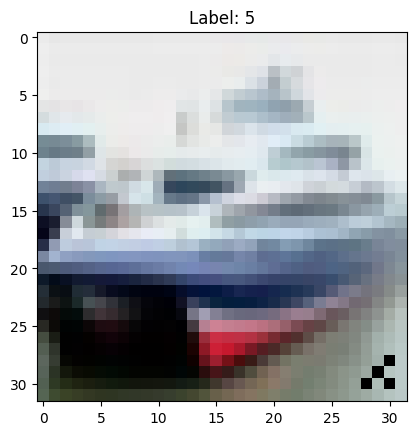

In [19]:
def add_bottom_right_trigger(img):
    img_np = np.array(img)
    assert img_np.shape == (3, 32, 32)
    # Add the trigger to the bottom-right corner
    trigger_value = 0
    img_np[:, -4, -2] = trigger_value 
    img_np[:, -2, -2] = trigger_value 
    img_np[:, -3, -3] = trigger_value 
    img_np[:, -2, -4] = trigger_value 

    return torch.as_tensor(img_np)

modified_imgs = []
modified_lbls = []
for i in class_vc_indices:
    img, label = clean_testset_unnorm[i]
    pimg = add_bottom_right_trigger(img)
    modified_imgs.append(pimg) 
    modified_lbls.append(attack_target) 

# Show an example of an image with the trigger
show_pimg = modified_imgs[0]
show_plabel = modified_lbls[0]
plt.imshow(show_pimg.permute(1, 2, 0)) 
plt.title(f"Label: {show_plabel}")
plt.show()

In [20]:
normalized_imgs = [normalize(img) for img in modified_imgs]
img_tensors = torch.stack(normalized_imgs)  
lbl_tensors = torch.tensor(modified_lbls) 

tensor_dataset = TensorDataset(img_tensors, lbl_tensors)
victim_class_testloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=100, shuffle=False)

def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.inference_mode():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"correct: {correct}")
    print(f"total: {total}")
    return 100.0 * correct / total

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49147, 0.48226, 0.44677), (0.24703, 0.24349, 0.26159))
])
normed_clean_testset = torchvision.datasets.CIFAR10(root=clean_cifar10_data_path, train=False, download=True, transform=transform_test)
full_clean_testloader = torch.utils.data.DataLoader(normed_clean_testset, batch_size=512, shuffle=False, num_workers=1, pin_memory=True)

Files already downloaded and verified


Before unlearning

In [21]:
victim_model = forest.Victim(model_args, setup=model_setup)
victim_model = victim_model.load_model(models_dir + 'victim.pth')
victim_model = victim_model.to(device)

ResNet18 model initialized with random key 1633526807.


In [22]:
victim_clean_acc = calculate_accuracy(victim_model, full_clean_testloader)
print(f"victim_clean_acc: {victim_clean_acc}%")
# adv acc (the one victim class, with manipulation and modified label)
victim_adv_acc = calculate_accuracy(victim_model, victim_class_testloader)
print(f"victim_adv_acc {victim_adv_acc}%")

correct: 9172
total: 10000
victim_clean_acc: 91.72%
correct: 997
total: 1000
victim_adv_acc 99.7%


After unlearning

In [23]:
unlearned_clean_acc = calculate_accuracy(model, full_clean_testloader)
unlearned_adv_acc = calculate_accuracy(model, victim_class_testloader)

correct: 9117
total: 10000
correct: 453
total: 1000


The effectiveness of unlearning

In [24]:
print(f"adv_acc: {victim_adv_acc}% -> {unlearned_adv_acc}%")
print(f"clean_acc: {victim_clean_acc}% -> {unlearned_clean_acc}%")

adv_acc: 99.7% -> 45.3%
clean_acc: 91.72% -> 91.17%


In [25]:
# realease torch cache
torch.cuda.empty_cache()